## Individual Category Breakdown

In [ ]:
# Step 1: Import required libraries
import pandas as pd


# Step 2: Load data
file_path = r"C:\Users\hp\Desktop\PT\Data science parttime\python\Voter Behavior Simulation and Prediction using LightGBM\demography.xlsx"
df_ethnicity = pd.read_excel(file_path, sheet_name="eternisity")
df_age = pd.read_excel(file_path, sheet_name="age")
df_gender = pd.read_excel(file_path, sheet_name="gender")

# Step 3: Reshape all dataframes into long format
ethnicity_long = pd.melt(df_ethnicity, id_vars="State", var_name="Ethnicity", value_name="Ethnicity_Percentage")
age_long = pd.melt(df_age, id_vars="State", var_name="Age_Group", value_name="Age_Percentage")
gender_long = pd.melt(df_gender, id_vars="State", var_name="Gender", value_name="Gender_Percentage")

# Step 4: Merge all dataframes on 'State'
merged_df = (
    age_long
    .merge(ethnicity_long, on="State")
    .merge(gender_long, on="State")
)

# Step 5: Calculate unnormalized joint percentage
merged_df["Unnormalized_Percentage"] = (
    merged_df["Age_Percentage"] *
    merged_df["Ethnicity_Percentage"] *
    merged_df["Gender_Percentage"]
)

# Step 6: Normalize so that sum per state equals 100%
merged_df["Final_Percentage"] = (
    merged_df
    .groupby("State")["Unnormalized_Percentage"]
    .transform(lambda x: (x / x.sum()) * 100)
)

# Step 7: Round the result
merged_df["Final_Percentage"] = merged_df["Final_Percentage"].round(4)

# Step 8: Export the merged data
output_file = r"C:\Users\hp\Desktop\PT\Data science parttime\python\Voter Behavior Simulation and Prediction using LightGBM\US_Demographic_Breakdown.xlsx"
merged_df.to_excel(output_file, index=False)

print("✅ Excel file saved at:", output_file)


## Balancing data  for all the column 

In [3]:
import pandas as pd
from sklearn.utils import resample

# Load data
df_demo = pd.read_excel("US Demographic Breakdown.xlsx", sheet_name='Sheet1')
df_survey = pd.read_excel("usa survey data main after cleaning.xlsx", sheet_name='usa survey data main')

# Standardize column names
df_demo.columns = df_demo.columns.str.strip()
df_survey.columns = df_survey.columns.str.strip().str.lower()

# Define columns to preserve
trend_columns = [
    'voting_preference', 'biggest_issues',
    'state_govt_performance', 'federal_govt_performance', 'opposition_performance',
    'election_winner_prediction', 'best_govt_choice',
    'trust_in_media', 'top_media_source', 'immigration_policy_opinion',
    'climate_change_priority', 'gun_control_support', 'abortion_rights_opinion',
    'party_affiliation'
]
same_columns = [
    'education_level', 'occupation','monthly_household_income'
]

# Clean up
for col in ['state', 'age', 'gender', 'ethnicity'] + trend_columns:
    if col in df_survey.columns:
        df_survey[col] = df_survey[col].astype(str).str.strip()

for col in ['State', 'Age_Group', 'Gender', 'Ethnicity']:
    df_demo[col] = df_demo[col].astype(str).str.strip()

# Create demographic group keys
df_survey['group'] = df_survey['ethnicity'] + '_' + df_survey['gender'] + '_' + df_survey['age']
df_demo['group'] = df_demo['Ethnicity'] + '_' + df_demo['Gender'] + '_' + df_demo['Age_Group']

# Final dataset container
final = pd.DataFrame()

for state in df_survey['state'].unique():
    print(f"\nProcessing {state}...")

    df_state = df_survey[df_survey['state'] == state].copy()
    df_demo_state = df_demo[df_demo['State'].str.lower() == state.lower()].copy()

    if df_demo_state.empty:
        print(f"[Skipped] No demographics for {state}")
        continue

    total_target = len(df_state)
    balanced_state = pd.DataFrame()

    for _, demo_row in df_demo_state.iterrows():
        group_key = demo_row['group']
        group_pct = float(str(demo_row['Final_Percentage']).replace('%', ''))
        group_target = int(round(total_target * group_pct / 100))

        df_group = df_state[df_state['group'] == group_key]

        if df_group.empty:
            continue

        if len(df_group) >= group_target:
            # Enough samples, just sample
            df_final_group = df_group.sample(n=group_target, random_state=42)
        else:
            # Not enough — resample preserving trend combinations
            df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
            combo_counts = df_group['trend_combo'].value_counts(normalize=True)

            dfs = []
            for combo, combo_pct in combo_counts.items():
                combo_target = int(round(group_target * combo_pct))
                df_combo = df_group[df_group['trend_combo'] == combo]

                if df_combo.empty:
                    continue

                df_resampled = resample(df_combo, replace=True, n_samples=combo_target, random_state=42)
                dfs.append(df_resampled)

            df_final_group = pd.concat(dfs, ignore_index=True)

        balanced_state = pd.concat([balanced_state, df_final_group], ignore_index=True)

    print(f"[Done] Final samples for {state}: {len(balanced_state)}")
    final = pd.concat([final, balanced_state], ignore_index=True)

# Save only specified columns
all_needed_columns = ['state', 'age', 'gender', 'ethnicity'] + trend_columns + same_columns
final = final.loc[:, [col for col in all_needed_columns if col in final.columns]]

# Save to Excel
final.to_excel("USA Servey data after balance.xlsx", index=False)
print("\n✅ Balancing complete. Output saved to Balanced_US_Survey_With_All_Trends.xlsx.")


Processing California...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for California: 8390

Processing Texas...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Texas: 8536

Processing Florida...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Florida: 9180

Processing New York...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for New York: 8472

Processing Pennsylvania...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Pennsylvania: 8579

Processing Illinois...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Illinois: 8432

Processing Ohio...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Ohio: 8681

Processing Georgia...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Georgia: 8762

Processing North Carolina...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for North Carolina: 8572

Processing Michigan...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Michigan: 8693

Processing New Jersey...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for New Jersey: 8432

Processing Virginia...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Virginia: 8539

Processing Washington...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Washington: 8848

Processing Arizona...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Arizona: 8952

Processing Massachusetts...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Massachusetts: 8766

Processing Tennessee...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Tennessee: 8406

Processing Indiana...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Indiana: 8792

Processing Missouri...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Missouri: 8895

Processing Maryland...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Maryland: 8803

Processing Wisconsin...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Wisconsin: 8642

Processing Colorado...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Colorado: 8491

Processing Minnesota...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Minnesota: 8756

Processing South Carolina...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for South Carolina: 8626

Processing Alabama...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Alabama: 8441

Processing Louisiana...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Louisiana: 8895

Processing Kentucky...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Kentucky: 8627

Processing Oregon...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Oregon: 8842

Processing Oklahoma...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Oklahoma: 8859

Processing Connecticut...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Connecticut: 8706

Processing Utah...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Utah: 8403

Processing Iowa...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Iowa: 8581

Processing Nevada...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Nevada: 8872

Processing Arkansas...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Arkansas: 8641

Processing Mississippi...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Mississippi: 8422

Processing Kansas...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Kansas: 8953

Processing New Mexico...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for New Mexico: 8891

Processing Nebraska...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Nebraska: 8984

Processing Idaho...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Idaho: 8571

Processing West Virginia...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for West Virginia: 8659

Processing Hawaii...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Hawaii: 8655

Processing New Hampshire...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for New Hampshire: 8536

Processing Maine...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Maine: 8691

Processing Rhode Island...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Rhode Island: 8697

Processing Montana...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Montana: 8535

Processing Delaware...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Delaware: 8455

Processing South Dakota...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for South Dakota: 8793

Processing North Dakota...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for North Dakota: 8604

Processing Alaska...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Alaska: 8971

Processing Vermont...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Vermont: 8552

Processing District of Columbia...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for District of Columbia: 8757

Processing Wyoming...


C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group['trend_combo'] = df_group[trend_columns].astype(str).agg('|'.join, axis=1)
C:\Users\hp\AppData\Local\Temp\ipykernel_7860\464068231.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy 

[Done] Final samples for Wyoming: 9107

✅ Balancing complete. Output saved to Balanced_US_Survey_With_All_Trends.xlsx.


## Checking before and after trends

In [4]:
import pandas as pd

# Load data
original = pd.read_csv("usa survey data main after cleaning.xlsx")
balanced = pd.read_excel("USA Servey data after balance.xlsx")

# Clean columns
for df in [original, balanced]:
    for col in ['state', 'age', 'gender', 'ethnicity', 'voting_preference']:
        df[col] = df[col].astype(str).str.strip()
    df['group'] = df['ethnicity'] + '_' + df['gender'] + '_' + df['age']

# Track results
tracking = []

# Unique (state, group) pairs in balanced set
for (state, group), df_bal in balanced.groupby(['state', 'group']):
    df_orig = original[(original['state'] == state) & (original['ethnicity'] + '_' + original['gender'] + '_' + original['age'] == group)]

    original_count = len(df_orig)
    balanced_count = len(df_bal)

    original_dist = df_orig['voting_preference'].value_counts(normalize=True).to_dict() if original_count > 0 else {}
    balanced_dist = df_bal['voting_preference'].value_counts(normalize=True).to_dict()

    tracking.append({
        'state': state,
        'group': group,
        'original_count': original_count,
        'balanced_count': balanced_count,
        'added_count': max(0, balanced_count - original_count),
        'original_dist': original_dist,
        'new_dist': balanced_dist
    })

# Save report
df_tracking = pd.DataFrame(tracking)
df_tracking.to_excel("Balancing Tracking Report.xlsx", index=False)
print("✅ Tracking report saved to Balancing_Tracking_Report.xlsx")


UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte

## correlation factors

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO

# Load the cleaned and balanced survey dataset
df = pd.read_excel("USA Servey data after balance.xlsx")

# Clean columns
df.columns = df.columns.str.strip().str.lower()
for col in ['voting_preference', 'age', 'gender', 'ethnicity', 'state']:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Create party binary flags (modify these if your party names differ)
df['democrats_support'] = df['voting_preference'].apply(lambda x: 1 if 'democrat' in x else 0)
df['republicans_support'] = df['voting_preference'].apply(lambda x: 1 if 'republican' in x else 0)
df['others_support'] = df['voting_preference'].apply(lambda x: 1 if x not in ['democrats', 'republicans'] else 0)

# Output Excel file
output_path = "US_Statewise_Correlation_by_Party.xlsx"
states = df['state'].unique()

with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
    for state in states:
        state_df = df[df['state'] == state.lower()]

        # One-hot encode demographic columns
        encoded = pd.get_dummies(state_df[['age', 'gender', 'ethnicity']], drop_first=False)

        # Skip if there's no variation in data
        if encoded.nunique().sum() <= 1:
            print(f"[Skipped] {state} - Not enough demographic variation.")
            continue

        # Combine with party flags
        combined = pd.concat([encoded, state_df[['democrats_support', 'republicans_support', 'others_support']]], axis=1)

        # Correlation matrix
        corr = combined.corr()

        try:
            result = pd.DataFrame({
                'Democrats': corr['democrats_support'].drop(['democrats_support', 'republicans_support', 'others_support']),
                'Republicans': corr['republicans_support'].drop(['democrats_support', 'republicans_support', 'others_support']),
                'Others': corr['others_support'].drop(['democrats_support', 'republicans_support', 'others_support']),
            })
        except KeyError:
            print(f"[Skipped] {state} - Missing party columns.")
            continue

        if result.isnull().all().all() or result.empty:
            print(f"[Skipped] {state} - All correlations are NaN.")
            continue

        # Format sheet name for Excel
        sheet_name = state.strip().replace(" ", "_").replace("/", "-")[:31]
        result.to_excel(writer, sheet_name=sheet_name)

        # Draw heatmap
        workbook = writer.book
        worksheet = writer.sheets[sheet_name]
        plt.figure(figsize=(6, 5))
        sns.heatmap(result, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
        plt.title(f"Demographic-Party Correlation - {state}")
        plt.tight_layout()

        # Save image and insert into Excel
        image_stream = BytesIO()
        plt.savefig(image_stream, format='png')
        plt.close()
        image_stream.seek(0)
        worksheet.insert_image("F2", f"{state}_heatmap.png", {'image_data': image_stream})

print(f"\n✅ Done! Correlation heatmaps saved to: {output_path}")



✅ Done! Correlation heatmaps saved to: US_Statewise_Correlation_by_Party.xlsx


## Random Forest for prediction of undecided voters

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load your data
df = pd.read_excel("USA Servey data after balance.xlsx")  # Adjust path

In [8]:
state = "California"
df_state = df[df['state'] == state].copy()


In [9]:
# Training data: only those with known voting preference
df_train = df_state[df_state['voting_preference'].isin(['Democrats', 'Republicans'])].copy()

# Prediction target: rows where voting_preference is 'Undecided'
df_predict = df_state[df_state['voting_preference'] == 'Undecided'].copy()


In [10]:
X_train = df_train.drop(columns=['voting_preference'])
y_train = df_train['voting_preference']

X_predict = df_predict.drop(columns=['voting_preference'])

# Drop ID or free-text columns if needed
cols_to_drop = ['state']  # Drop if state is fixed
X_train = X_train.drop(columns=cols_to_drop)
X_predict = X_predict.drop(columns=cols_to_drop)


In [11]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)


In [12]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Optional: cross-validation score
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation Accuracy ({}): {:.2f}%".format(state, scores.mean() * 100))


Cross-validation Accuracy (California): 48.44%


In [13]:
y_pred = model.predict(X_predict)

# Assign predictions to original DataFrame
df.loc[df['state'] == state, 'voting_preference'] = df.loc[df['state'] == state].apply(
    lambda row: y_pred[df_predict.index.get_loc(row.name)] if row['voting_preference'] == 'Undecided' else row['voting_preference'],
    axis=1
)


In [14]:
for state in df['state'].unique():
    df_state = df[df['state'] == state].copy()
    df_train = df_state[df_state['voting_preference'].isin(['Democrats', 'Republicans'])].copy()
    df_predict = df_state[df_state['voting_preference'] == 'Undecided'].copy()

    if df_train.empty or df_predict.empty:
        continue  # Skip if no data

    X_train = df_train.drop(columns=['voting_preference', 'state'])
    y_train = df_train['voting_preference']
    X_predict = df_predict.drop(columns=['voting_preference', 'state'])

    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_predict)

    df.loc[df['state'] == state, 'voting_preference'] = df.loc[df['state'] == state].apply(
        lambda row: y_pred[df_predict.index.get_loc(row.name)] if row['voting_preference'] == 'Undecided' else row['voting_preference'],
        axis=1
    )


In [15]:
df.to_excel("usa servey data after prediction undecided.xlsx", index=False)


## Random Forest Classifier simulater

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_excel("usa servey data after prediction undecided.xlsx")

# Configuration
target_col = 'voting_preference'
demographic_cols = ['age', 'gender', 'ethnicity']
state_col = 'state'
change_range = list(range(-30, 31, 5))  # -30% to +30%

# Drop missing values
df = df.dropna(subset=demographic_cols + [target_col, state_col])

# Encode target
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])
target_classes = le_target.classes_

# Encode demographics
label_encoders = {}
for col in demographic_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Helper function to adjust distribution
def adjust_distribution(df, column, value, change_percent):
    df_mod = df.copy()
    current_ratio = (df_mod[column] == value).mean()
    desired_ratio = current_ratio + (change_percent / 100)

    if desired_ratio < 0 or desired_ratio > 1:
        return None

    total_count = len(df_mod)
    desired_count = int(desired_ratio * total_count)
    current_count = (df_mod[column] == value).sum()

    if desired_count > current_count:
        others = df_mod[df_mod[column] != value]
        if others.empty: return None
        sampled = others.sample(n=(desired_count - current_count), replace=True, random_state=42)
        df_mod.loc[sampled.index, column] = value
    elif desired_count < current_count:
        current = df_mod[df_mod[column] == value]
        if current.empty: return None
        sampled = current.sample(n=(current_count - desired_count), random_state=42)
        alt_value = df_mod[column].value_counts().index[1]
        df_mod.loc[sampled.index, column] = alt_value

    return df_mod

# Run simulation for all states and subcategories
results = []
states = df[state_col].unique()

for state in states:
    state_df = df[df[state_col] == state].copy()
    if len(state_df) < 50:
        continue

    y = state_df[target_col]
    X = pd.get_dummies(state_df[demographic_cols], drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    orig_dist = pd.Series(le_target.inverse_transform(state_df[target_col])).value_counts(normalize=True)

    for demo_col in demographic_cols:
        for subcat in df[demo_col].unique():
            for change in change_range:
                df_mod = adjust_distribution(state_df, demo_col, subcat, change)
                if df_mod is None:
                    continue

                X_mod = pd.get_dummies(df_mod[demographic_cols], drop_first=True)
                X_mod = X_mod.reindex(columns=X.columns, fill_value=0)
                y_pred = model.predict(X_mod)
                pred_labels = le_target.inverse_transform(y_pred)
                pred_dist = pd.Series(pred_labels).value_counts(normalize=True)

                dem_share = pred_dist.get('Democrats', 0.0)
                rep_share = pred_dist.get('Republicans', 0.0)
                winner = 'Democrats' if dem_share > rep_share else 'Republicans'

                results.append({
                    "state": state,
                    "demographic_column": demo_col,
                    "subcategory": label_encoders[demo_col].inverse_transform([subcat])[0],
                    "change_percent": change,
                    "democrat_share": round(dem_share * 100, 2),
                    "republican_share": round(rep_share * 100, 2),
                    "winner_prediction": winner,
                    "Original Composition of Democrats": round(orig_dist.get('Democrats', 0.0) * 100, 2),
                    "Original Composition of Republicans": round(orig_dist.get('Republicans', 0.0) * 100, 2)
                })

# Save results
results_df = pd.DataFrame(results)
output_path = "USA simulation output.xlsx"
results_df.to_excel(output_path, index=False)
output_path

'USA simulation output.xlsx'

## Confusion matrix & Classification report (which includes F1-score, precision, and recall for each class)


✅ Model Accuracy: 0.5604

📊 Confusion Matrix:
[[775 224]
 [577 246]]

📄 Classification Report:
              precision    recall  f1-score   support

   Democrats       0.57      0.78      0.66       999
 Republicans       0.52      0.30      0.38       823

    accuracy                           0.56      1822
   macro avg       0.55      0.54      0.52      1822
weighted avg       0.55      0.56      0.53      1822



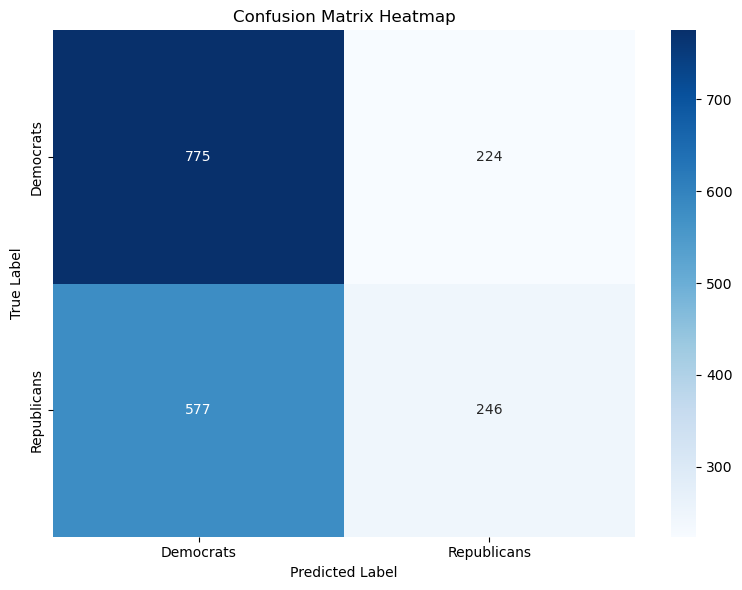


🏆 ROC AUC Score (Binary): 0.5923


In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === PREDICTIONS ===
# Predict class labels
y_pred = model.predict(X_test)

# === ACCURACY ===
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {accuracy:.4f}")

# === CONFUSION MATRIX ===
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(conf_matrix)

# === CLASSIFICATION REPORT ===
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_classes))

# === CONFUSION MATRIX HEATMAP ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_classes, yticklabels=target_classes)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === ROC AUC SCORE ===
try:
    y_pred_probs = model.predict_proba(X_test)

    if len(target_classes) == 2:
        # Binary classification — use probability for class 1
        y_pred_probs_binary = y_pred_probs[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_probs_binary)
        print(f"\n🏆 ROC AUC Score (Binary): {roc_auc:.4f}")
    else:
        # Multiclass classification
        roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
        print(f"\n🏆 ROC AUC Score (Multiclass OvR): {roc_auc:.4f}")

except Exception as e:
    print(f"\n⚠️ ROC AUC Score could not be computed: {e}")


## Light GBM using SMOTE

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the balanced USA dataset
df = pd.read_excel("Balanced US Survey.xlsx")

# Ensure 'state' column exists
if 'state' not in df.columns:
    raise ValueError("Column 'state' not found in dataset.")

# Encode categorical variables
label_encoders = {}
for col in ['ethnicity', 'gender', 'age', 'voting_preference']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare features and target
X = df[['ethnicity', 'gender', 'age']]
y = df['voting_preference']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model for multiclass classification
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoders['voting_preference'].classes_),
    'metric': 'multi_logloss',
    'verbose': -1
}
model = lgb.train(params, lgb_train, num_boost_round=100)

# Dictionary to store results
all_results = {}

# Process each state separately
states = df['state'].unique()

for state in states:
    state_data = []
    state_df = df[df['state'] == state]

    all_ethnicities = state_df['ethnicity'].unique()
    all_ages = state_df['age'].unique()
    all_genders = state_df['gender'].unique()

    demographic_categories = (
        [('gender', gender) for gender in all_genders] +
        [('ethnicity', eth) for eth in all_ethnicities] +
        [('age', age) for age in all_ages]
    )

    # Predict original vote distribution in state
    original_predictions = np.argmax(model.predict(state_df[['ethnicity', 'gender', 'age']]), axis=1)

    total_votes = len(state_df)

    original_counts = {}
    for cls_idx, cls_name in enumerate(label_encoders['voting_preference'].classes_):
        original_counts[cls_name] = (original_predictions == cls_idx).sum()

    original_compositions = {k: (v / total_votes) * 100 for k, v in original_counts.items()}

    for category, subcategory in demographic_categories:
        if category in label_encoders:
            subcategory_original = label_encoders[category].inverse_transform([subcategory])[0]
        else:
            subcategory_original = subcategory

        # Vary percentage from -30% to +30% in steps of 5%
        for percentage_change in range(-30, 31, 5):
            modified_data = state_df.copy()

            affected_samples = int(len(modified_data[modified_data[category] == subcategory]) * abs(percentage_change) / 100)

            if affected_samples == 0:
                # No samples to add or remove, skip iteration
                continue

            if percentage_change > 0:
                additional_rows = modified_data[modified_data[category] == subcategory].sample(n=affected_samples, replace=True, random_state=42)
                modified_data = pd.concat([modified_data, additional_rows])
            elif percentage_change < 0:
                drop_indices = modified_data[modified_data[category] == subcategory].sample(n=affected_samples, replace=False, random_state=42).index
                modified_data = modified_data.drop(drop_indices)

            new_predictions = np.argmax(model.predict(modified_data[['ethnicity', 'gender', 'age']]), axis=1)

            adjusted_counts = {}
            for cls_idx, cls_name in enumerate(label_encoders['voting_preference'].classes_):
                adjusted_counts[cls_name] = (new_predictions == cls_idx).sum()

            adjusted_compositions = {k: (v / len(modified_data)) * 100 for k, v in adjusted_counts.items()}

            max_vote = max(adjusted_compositions.values())
            winner = max(adjusted_compositions, key=adjusted_compositions.get)

            state_data.append({
                'State': state,
                'Category': category,
                'Subcategory': subcategory_original,
                'Percentage Change': percentage_change,
                **{f'Change Composition of {party}': round(adjusted_compositions.get(party, 0), 1) for party in label_encoders['voting_preference'].classes_},
                'Winner': winner,
                **{f'Original Composition of {party}': round(original_compositions.get(party, 0), 1) for party in label_encoders['voting_preference'].classes_},
            })

    all_results[state] = pd.DataFrame(state_data )

# Combine all state results into one dataframe
combined_results = pd.concat(all_results.values(), ignore_index=True)

# Save to Excel
output_file = "US_Voter_Simulation_Results.xlsx"
combined_results.to_excel(output_file, sheet_name='Combined Results', index=False)

print(f"Simulation complete. All results saved to '{output_file}'.")

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Load data
df_demo = pd.read_excel("US Demographic Breakdown.xlsx", sheet_name='Sheet1')
df_survey = pd.read_excel("usa dummy statewise survey data main.xlsx", sheet_name='usa dummy statewise survey data')

# Standardize column names
df_demo.columns = df_demo.columns.str.strip()
df_survey.columns = df_survey.columns.str.strip().str.lower()

# Define columns to preserve
trend_columns = [
    'voting_preference', 'survey_status', 'biggest_issues',
    'state_govt_performance', 'federal_govt_performance', 'opposition_performance',
    'election_winner_prediction', 'best_govt_choice', 'monthly_household_income',
    'trust_in_media', 'top_media_source', 'immigration_policy_opinion',
    'climate_change_priority', 'gun_control_support', 'abortion_rights_opinion',
    'party_affiliation'
]
same_columns = [
    'call_date', 'agent_id', 'respondent_name', 'education_level', 'occupation'
]

# Clean up
for col in ['state', 'age', 'gender', 'ethnicity'] + trend_columns:
    if col in df_survey.columns:
        df_survey[col] = df_survey[col].astype(str).str.strip()

for col in ['State', 'Age_Group', 'Gender', 'Ethnicity']:
    df_demo[col] = df_demo[col].astype(str).str.strip()

# Create demographic group keys
df_survey['group'] = df_survey['ethnicity'] + '_' + df_survey['gender'] + '_' + df_survey['age']
df_demo['group'] = df_demo['Ethnicity'] + '_' + df_demo['Gender'] + '_' + df_demo['Age_Group']

# Final dataset container
final = pd.DataFrame()

for state in df_survey['state'].unique():
    print(f"\nProcessing {state}...")

    df_state = df_survey[df_survey['state'] == state].copy()
    df_demo_state = df_demo[df_demo['State'].str.lower() == state.lower()].copy()

    if df_demo_state.empty:
        print(f"[Skipped] No demographics for {state}")
        continue

    total_target = len(df_state)
    balanced_state = pd.DataFrame()

    for _, demo_row in df_demo_state.iterrows():
        group_key = demo_row['group']
        group_pct = float(str(demo_row['Final_Percentage']).replace('%', ''))
        group_target = int(round(total_target * group_pct / 100))

        df_group = df_state[df_state['group'] == group_key]

        if df_group.empty:
            continue

        # If enough samples, keep as-is
        if len(df_group) >= group_target:
            df_final_group = df_group.sample(n=group_target, random_state=42)
        else:
            dfs = []

            for trend_col in trend_columns:
                if trend_col not in df_group.columns:
                    continue

                class_counts = df_group[trend_col].value_counts(normalize=True)

                for cls_val, cls_pct in class_counts.items():
                    cls_target = int(round(group_target * cls_pct))
                    df_cls = df_group[df_group[trend_col] == cls_val]

                    if df_cls.empty:
                        continue

                    df_resampled = resample(df_cls, replace=True, n_samples=cls_target, random_state=42)
                    dfs.append(df_resampled)

            df_final_group = pd.concat(dfs, ignore_index=True).drop_duplicates()

        balanced_state = pd.concat([balanced_state, df_final_group], ignore_index=True)

    print(f"[Done] Final samples for {state}: {len(balanced_state)}")
    final = pd.concat([final, balanced_state], ignore_index=True)

# Save only specified columns
all_needed_columns = ['state', 'age', 'gender', 'ethnicity'] + trend_columns + same_columns
final = final.loc[:, [col for col in all_needed_columns if col in final.columns]]

final.to_excel("Balanced_US_Survey_With_All_Trends.xlsx", index=False)
print("\n✅ Balancing complete. Output saved to Balanced_US_Survey_With_All_Trends.xlsx.")


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_excel("Balanced_US_Survey_With_All_Trends.xlsx")

# Check voting preference distribution
print("Voting preference counts:")
print(df['voting_preference'].value_counts())

# Encode categorical variables
label_encoders = {}
for col in ['age', 'gender', 'ethnicity', 'voting_preference','education_level','occupation','monthly_household_income','biggest_issues','state_govt_performance','federal_govt_performance','opposition_performance','election_winner_prediction','best_govt_choice','trust_in_media','top_media_source','immigration_policy_opinion','climate_change_priority','gun_control_support','abortion_rights_opinion','party_affiliation','voting_preference']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features and target
X = df[['age', 'gender', 'ethnicity','education_level','occupation','monthly_household_income','biggest_issues','state_govt_performance','federal_govt_performance','opposition_performance','election_winner_prediction','best_govt_choice','trust_in_media','top_media_source','immigration_policy_opinion','climate_change_priority','gun_control_support','abortion_rights_opinion','party_affiliation']]
y = df['voting_preference']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train LightGBM multiclass model
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoders['voting_preference'].classes_),
    'metric': 'multi_logloss',
    'verbose': -1,
    'seed': 42,
    'learning_rate': 0.05,
    'num_leaves': 31,
}

model = lgb.train(params, lgb_train, num_boost_round=100)

# Evaluate on test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")

# Prepare to run simulations per state and demographic group
results = []

states = df['state'].unique()

for state in states:
    df_state = df[df['state'] == state].copy()
    
    # Decode voting preference to string for final reporting
    df_state['voting_pref_str'] = label_encoders['voting_preference'].inverse_transform(df_state['voting_preference'])
    
    # Original vote distribution
    orig_counts = df_state['voting_pref_str'].value_counts(normalize=True)
    
    # Get unique demographic categories and their encodings
    for category in ['age', 'gender', 'ethnicity','education_level','occupation','monthly_household_income','biggest_issues','state_govt_performance','federal_govt_performance','opposition_performance','election_winner_prediction','best_govt_choice','trust_in_media','top_media_source','immigration_policy_opinion','climate_change_priority','gun_control_support','abortion_rights_opinion','party_affiliation']:
        unique_cats = df_state[category].unique()
        
        for cat in unique_cats:
            # Decode for reporting
            cat_str = label_encoders[category].inverse_transform([cat])[0]
            
            for pct_change in range(-30, 31, 5):
                modified_df = df_state.copy()
                
                # Samples in this demographic group
                group_idx = modified_df[modified_df[category] == cat].index
                
                n_to_change = int(len(group_idx) * abs(pct_change) / 100)
                
                if pct_change > 0:
                    # Upsample group by sampling with replacement
                    if n_to_change > 0:
                        samples_to_add = modified_df.loc[group_idx].sample(n=n_to_change, replace=True, random_state=42)
                        modified_df = pd.concat([modified_df, samples_to_add], ignore_index=True)
                elif pct_change < 0:
                    # Downsample group by dropping samples
                    if n_to_change > 0:
                        drop_idx = modified_df.loc[group_idx].sample(n=n_to_change, random_state=42).index
                        modified_df = modified_df.drop(drop_idx).reset_index(drop=True)
                
                # Prepare features for prediction
                X_mod = modified_df[['age', 'gender', 'ethnicity','education_level','occupation','monthly_household_income','biggest_issues','state_govt_performance','federal_govt_performance','opposition_performance','election_winner_prediction','best_govt_choice','trust_in_media','top_media_source','immigration_policy_opinion','climate_change_priority','gun_control_support','abortion_rights_opinion','party_affiliation']]
                
                # Predict voting preference probabilities
                preds_prob = model.predict(X_mod)
                preds_class = np.argmax(preds_prob, axis=1)
                
                # Decode predictions
                preds_str = label_encoders['voting_preference'].inverse_transform(preds_class)
                
                # Calculate vote distribution in modified data
                vote_dist = pd.Series(preds_str).value_counts(normalize=True)
                
                # Prepare result dict with zeros default
                res = {
                    'State': state,
                    'Category': category,
                    'Subcategory': cat_str,
                    'Percentage Change': pct_change,
                    'Change Composition of Democrats': vote_dist.get('Democrats', 0)*100,
                    'Change Composition of Republicans': vote_dist.get('Republicans', 0)*100,
                    'Winner': vote_dist.idxmax() if not vote_dist.empty else 'N/A',
                    'Original Composition of Democrats': orig_counts.get('Democrats', 0)*100,
                    'Original Composition of Republicans': orig_counts.get('Republicans', 0)*100,
                }
                
                results.append(res)

# Save to Excel
df_results = pd.DataFrame(results)
output_file = "US_Voter_Simulation_Results123.xlsx"
df_results.to_excel(output_file, index=False)

print(f"Simulation complete. Results saved to '{output_file}'")

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
from collections import defaultdict
from tqdm import tqdm

# Load dataset
df = pd.read_excel("Balanced_US_Survey_With_All_Trends.xlsx")

# Encode all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split into features and target
X = df.drop("voting_preference", axis=1)
y = df["voting_preference"]




# Ensure stratified split if class imbalance exists
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Train LightGBM classifier
model = LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.4f}")

# Reverse mapping for predictions
voting_le = label_encoders["voting_preference"]
state_le = label_encoders["state"]

# Start simulation
results = []
states = df["state"].unique()
demographic_cols = ['age', 'gender', 'ethnicity', 'education_level', 'occupation']

for state in tqdm(states, desc="Simulating states"):
    original_state_df = df[df["state"] == state].copy()

    for demo_col in demographic_cols:
        subcategories = df[demo_col].unique()

        for subcat in subcategories:
            for change in range(-30, 31, 10):  # -30% to +30% in 10% steps
                modified_df = original_state_df.copy()

                # Calculate new sample size
                subcat_mask = modified_df[demo_col] == subcat
                subcat_df = modified_df[subcat_mask]
                others_df = modified_df[~subcat_mask]

                change_ratio = 1 + (change / 100)
                new_size = int(len(subcat_df) * change_ratio)

                if new_size <= 0:
                    continue

                if change > 0:
                    subcat_resampled = subcat_df.sample(n=new_size, replace=True, random_state=42)
                else:
                    subcat_resampled = subcat_df.sample(n=new_size, replace=False, random_state=42)

                simulated_df = pd.concat([subcat_resampled, others_df])
                simulated_X = simulated_df.drop("voting_preference", axis=1)

                # Predict
                preds = model.predict(simulated_X)
                pred_labels = voting_le.inverse_transform(preds)

                # Count votes
                pred_counts = pd.Series(pred_labels).value_counts(normalize=True)
                dem_share = pred_counts.get('Democrats', 0)
                rep_share = pred_counts.get('Republicans', 0)
                winner = 'Democrats' if dem_share > rep_share else 'Republicans' if rep_share > dem_share else 'Tie'

                results.append({
                    "state": state_le.inverse_transform([state])[0],
                    "demographic_column": demo_col,
                    "subcategory": label_encoders[demo_col].inverse_transform([subcat])[0],
                    "change_percent": change,
                    "democrat_share": round(dem_share * 100, 2),
                    "republican_share": round(rep_share * 100, 2),
                    "winner_prediction": winner
                    "Original Composition of Democrats": orig_counts.get('Democrats', 0)*100,
                    "Original Composition of Republicans": orig_counts.get('Republicans', 0)*100,
                    
                })

# Export to Excel
results_df = pd.DataFrame(results)
results_df.to_excel("US_Voter_Simulation_Results123.xlsx", index=False)
print("✅ Simulation complete. File saved as US_Voter_Simulation_Results123.xlsx.")

SyntaxError: invalid syntax (218113733.py, line 97)

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Load dataset
df = pd.read_excel("Balanced_US_Survey_With_All_Trends.xlsx")

# Encode all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Split into features and target
X = df.drop("voting_preference", axis=1)
y = df["voting_preference"]

# Ensure stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train LightGBM classifier
model = LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

# Evaluate model
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.4f}")

# Reverse mapping for predictions
voting_le = label_encoders["voting_preference"]
state_le = label_encoders["state"]

# Start simulation
results = []
states = df["state"].unique()
demographic_cols = ['age', 'gender', 'ethnicity', 'education_level', 'occupation']

for state in tqdm(states, desc="Simulating states"):
    original_state_df = df[df["state"] == state].copy()

    # Calculate original composition for this state
    orig_y = original_state_df["voting_preference"]
    orig_counts = pd.Series(voting_le.inverse_transform(orig_y)).value_counts(normalize=True)

    for demo_col in demographic_cols:
        subcategories = df[demo_col].unique()

        for subcat in subcategories:
            for change in range(-30, 31, 10):  # -30% to +30%
                modified_df = original_state_df.copy()

                # Create masks and sample
                subcat_mask = modified_df[demo_col] == subcat
                subcat_df = modified_df[subcat_mask]
                others_df = modified_df[~subcat_mask]

                change_ratio = 1 + (change / 100)
                new_size = int(len(subcat_df) * change_ratio)
                if new_size <= 0:
                    continue

                subcat_resampled = subcat_df.sample(
                    n=new_size,
                    replace=(change > 0),
                    random_state=42
                )

                simulated_df = pd.concat([subcat_resampled, others_df])
                simulated_X = simulated_df.drop("voting_preference", axis=1)

                # Predict
                preds = model.predict(simulated_X)
                pred_labels = voting_le.inverse_transform(preds)

                # Count votes
                pred_counts = pd.Series(pred_labels).value_counts(normalize=True)
                dem_share = pred_counts.get('Democrats', 0)
                rep_share = pred_counts.get('Republicans', 0)
                winner = 'Democrats' if dem_share > rep_share else 'Republicans' if rep_share > dem_share else 'Tie'

                results.append({
                    "state": state_le.inverse_transform([state])[0],
                    "demographic_column": demo_col,
                    "subcategory": label_encoders[demo_col].inverse_transform([subcat])[0],
                    "change_percent": change,
                    "democrat_share": round(dem_share * 100, 2),
                    "republican_share": round(rep_share * 100, 2),
                    "winner_prediction": winner,
                    "Original Composition of Democrats": round(orig_counts.get('Democrats', 0) * 100, 2),
                    "Original Composition of Republicans": round(orig_counts.get('Republicans', 0) * 100, 2)
                })

# Export results
results_df = pd.DataFrame(results)
results_df.to_excel("US_Voter_Simulation_Results123.xlsx", index=False)
print("✅ Simulation complete. File saved as US_Voter_Simulation_Results123.xlsx.")

[LightGBM] [Info] Number of positive: 123741, number of negative: 141810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 265551, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465978 -> initscore=-0.136297
[LightGBM] [Info] Start training from score -0.136297
Model Accuracy: 0.5907


Simulating states: 100%|███████████████████████████████████████████████████████████████| 51/51 [02:01<00:00,  2.38s/it]


✅ Simulation complete. File saved as US_Voter_Simulation_Results123.xlsx.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Role: Load and preprocess data
df = pd.read_excel("Balanced_US_Survey_With_All_Trends.xlsx")

# Objective: Predict 'voting_preference' using a trained ML model and simulate swing voter effects

# Context: Label encode all categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Instruction: Split into features (X) and target (y)
X = df.drop("voting_preference", axis=1)
y = df["voting_preference"]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train LightGBM classifier
model = LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Reverse mappings for decoding predictions
voting_le = label_encoders["voting_preference"]
state_le = label_encoders["state"]

# Define swing simulation parameters
swing_combinations = [(65, 35), (70, 30), (75, 25) , (60, 40) , (55, 45) ,(40, 60), (35, 65)]  # (Democrats, Republicans)
demographic_cols = ['age', 'gender', 'ethnicity', 'education_level', 'occupation']
states = df["state"].unique()

# Dictionary to store simulation results per state
all_results = {}

# Start swing voter simulation
for state in tqdm(states, desc="Simulating states"):
    state_name = state_le.inverse_transform([state])[0]
    state_data = df[df["state"] == state].copy()

    # Original party composition in the state
    y_original = state_data["voting_preference"]
    original_dist = pd.Series(voting_le.inverse_transform(y_original)).value_counts(normalize=True)

    # Identify top two ethnicities (as example swing segments)
    top_ethnicities = state_data['ethnicity'].value_counts().nlargest(2).index.tolist()
    swing_segments = [('gender', 'Male'), ('gender', 'Female')] + [('ethnicity', eth) for eth in top_ethnicities]

    state_results = []

    for swing_Dem, swing_Rep in swing_combinations:
        # Replace swing voters (encoded as a third label) with either Democrat or Republican based on swing ratio
        dependents = state_data[state_data['voting_preference'] == voting_le.transform(['Swing Voter'])[0]]
        total_dependents = len(dependents)

        dem_vote = len(state_data[state_data['voting_preference'] == voting_le.transform(['Democrats'])[0]]) + (total_dependents * swing_Dem / 100)
        rep_vote = len(state_data[state_data['voting_preference'] == voting_le.transform(['Republicans'])[0]]) + (total_dependents * swing_Rep / 100)

        total_votes = len(state_data)
        orig_dem_pct = (dem_vote / total_votes) * 100
        orig_rep_pct = (rep_vote / total_votes) * 100

        for cat, subcat in swing_segments:
            for pct_change in [-10, 10]:
                temp_df = state_data.copy()
                encoded_subcat = label_encoders[cat].transform([subcat])[0]
                mask = temp_df[cat] == encoded_subcat

                demo_data = temp_df[mask]
                non_demo_data = temp_df[~mask]
                new_count = int(len(demo_data) * (1 + pct_change / 100))

                if new_count <= 0:
                    continue

                sampled_demo = demo_data.sample(
                    n=new_count, replace=(pct_change > 0), random_state=42
                )
                combined_df = pd.concat([sampled_demo, non_demo_data])
                X_sim = combined_df.drop("voting_preference", axis=1)

                preds = model.predict(X_sim)
                decoded_preds = voting_le.inverse_transform(preds)
                pred_counts = pd.Series(decoded_preds).value_counts(normalize=True)

                dem_share = pred_counts.get('Democrats', 0)
                rep_share = pred_counts.get('Republicans', 0)
                winner = 'Democrats' if dem_share > rep_share else 'Republicans' if rep_share > dem_share else 'Tie'

                state_results.append({
                    "Swing Voter Percent (Dem/Rep)": f"{swing_Dem}/{swing_Rep}",
                    "Category": cat,
                    "Subcategory": subcat,
                    "Percentage Change": pct_change,
                    "Adjusted Support for": "Democrats" if pct_change > 0 else "Republicans",
                    "New Democrats Share": round(dem_share * 100, 2),
                    "New Republicans Share": round(rep_share * 100, 2),
                    "Winner": winner,
                    "Original Composition of Democrats": round(orig_dem_pct, 2),
                    "Original Composition of Republicans": round(orig_rep_pct, 2)
                })

    # Store results per state
    all_results[state_name] = pd.DataFrame(state_results)

# Output: Save all results into Excel with separate sheets
with pd.ExcelWriter("US_Voter_Simulation_Swing_LGBM.xlsx") as writer:
    for state, df_out in all_results.items():
        df_out.to_excel(writer, sheet_name=state[:31], index=False)  # Excel sheet limit

print("✅ Swing voter simulation complete. Results saved to 'US_Voter_Simulation_Swing_LGBM.xlsx'.")


KeyboardInterrupt: 

## Confusion matrix & Classification report (which includes F1-score, precision, and recall for each class)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is one-hot encoded, convert it to labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    
    y_test = np.argmax(y_test, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(conf_matrix)

# Classification Report: includes precision, recall, f1-score
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Confusion Matrix Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

try:
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"\n🏆 ROC AUC Score (OvR): {roc_auc:.4f}")
except Exception as e:
    print(f"\n⚠️ ROC AUC Score could not be computed: {e}")